# House Prices Regression Techniques
## Introduction

This notebook presents an experiment where a Stacked Model is compared with a Neural Network implementation. This is done with the aim to compare if Stacked models are capable to go head to head with a Neural Networks. The latter, which have gained more traction in recent years due to their capacity to perform feature extraction. The dataset used in the experiment in the House Prices - Advanced Regression Techniques from Kaggle competition. First, a data exploration phase will be conducted to extract the relevant pre-processing steps for the experiment. Then, the Stacking model will be built from three different models that will be selected at this time. The Neural Network will then be built and trained. Both models will be evaluated locally as a first benchmark using the same metric that the competition is using. The results will be submitted to the competition. Finally, a discussion section will be written with the aim to discuss the findings and discuss future work.

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.base import clone

## Data Exploration
### Data Loading
The Notebook can be used with `Google Colab`. To use it, place the competition's data under `MyDrive/data/houseprices` and run the notebook.

In [ ]:
from google.colab import drive

drive_mount = '/content/drive'

drive.mount(drive_mount)

df_train = pd.read_csv(drive_mount + '/MyDrive/data/houseprices/train.csv')
df_test = pd.read_csv(drive_mount + '/MyDrive/data/houseprices/test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Data Quality Report (DQR)
#### Continuous

In [ ]:
df_continuous = df_train.select_dtypes(include=["int64", "float64"])

def continuous_dqr(df):
    dqr_continuous = pd.DataFrame({
        'Features': df.columns,
        'Count': df.count(),
        'Missing Values': df.isnull().sum(),
        'Missing Values %': (df.isnull().sum() / len(df)) * 100,
        'Cardinality': df.nunique(),
        'Min': df.min(),
        '1st Quartile': df.quantile(0.25),
        'Mean': df.mean(),
        'Median': df.median(),
        '3rd Quartile': df.quantile(0.75),
        'Max': df.max(),
        'Standard Deviation': df.std(),
    })

    dqr_continuous.index = range(1, len(dqr_continuous) + 1)
    return dqr_continuous

continuous_dqr(df_continuous)

,Features,Count,Missing Values,Missing Values %,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
1,Id,1460,0,0.000000,1460,1.0,365.75,730.500000,730.5,1095.25,1460.0,421.610009
2,MSSubClass,1460,0,0.000000,15,20.0,20.00,56.897260,50.0,70.00,190.0,42.300571
3,LotFrontage,1201,259,17.739726,110,21.0,59.00,70.049958,69.0,80.00,313.0,24.284752
4,LotArea,1460,0,0.000000,1073,1300.0,7553.50,10516.828082,9478.5,11601.50,215245.0,9981.264932
5,OverallQual,1460,0,0.000000,10,1.0,5.00,6.099315,6.0,7.00,10.0,1.382997
6,OverallCond,1460,0,0.000000,9,1.0,5.00,5.575342,5.0,6.00,9.0,1.112799
7,YearBuilt,1460,0,0.000000,112,1872.0,1954.00,1971.267808,1973.0,2000.00,2010.0,30.202904
8,YearRemodAdd,1460,0,0.000000,61,1950.0,1967.00,1984.865753,1994.0,2004.00,2010.0,20.645407
9,MasVnrArea,1452,8,0.547945,327,0.0,0.00,103.685262,0.0,166.00,1600.0,181.066207
10,BsmtFinSF1,1460,0,0.000000,637,0.0,0.00,443.639726,383.5,712.25,5644.0,456.098091


#### Categorical

In [ ]:
def categorical_dqr(df):
    dqr_categorical = pd.DataFrame({
        'Features': df.columns,
        'Missing Values': df.isnull().sum(),
        'Missing Values %': (df.isnull().sum() / len(df)) * 100,
        'Cardinality': df.nunique(),
        'Mode': df.mode().iloc[0],
        'Mode Frequency': df.apply(lambda x: x.value_counts().values[0]),
        "Mode frequency %": df.apply(lambda x: (x.value_counts().values[0] / len(df)) * 100),
        "2nd mode": df.apply(lambda x: 'NA' if len(x.value_counts()) == 1 else x.value_counts().index[1]),
        "2nd mode frequency": df.apply(lambda x: 0 if len(x.value_counts()) == 1 else x.value_counts().values[1]),
        "2nd mode frequency %": df.apply(lambda x: 0 if len(x.value_counts()) == 1 else (x.value_counts().values[1]) / len(df)) * 100})

    dqr_categorical.index = range(1, len(dqr_categorical) + 1)
    return dqr_categorical

df_categorical = df_train.select_dtypes(include=["object"])
categorical_dqr(df_categorical)

,Features,Missing Values,Missing Values %,Cardinality,Mode,Mode Frequency,Mode frequency %,2nd mode,2nd mode frequency,2nd mode frequency %
1,MSZoning,0,0.000000,5,RL,1151,78.835616,RM,218,14.931507
2,Street,0,0.000000,2,Pave,1454,99.589041,Grvl,6,0.410959
3,Alley,1369,93.767123,2,Grvl,50,3.424658,Pave,41,2.808219
4,LotShape,0,0.000000,4,Reg,925,63.356164,IR1,484,33.150685
5,LandContour,0,0.000000,4,Lvl,1311,89.794521,Bnk,63,4.315068
6,Utilities,0,0.000000,2,AllPub,1459,99.931507,NoSeWa,1,0.068493
7,LotConfig,0,0.000000,5,Inside,1052,72.054795,Corner,263,18.013699
8,LandSlope,0,0.000000,3,Gtl,1382,94.657534,Mod,65,4.452055
9,Neighborhood,0,0.000000,25,NAmes,225,15.410959,CollgCr,150,10.273973
10,Condition1,0,0.000000,9,Norm,1260,86.301370,Feedr,81,5.547945


### Correlations

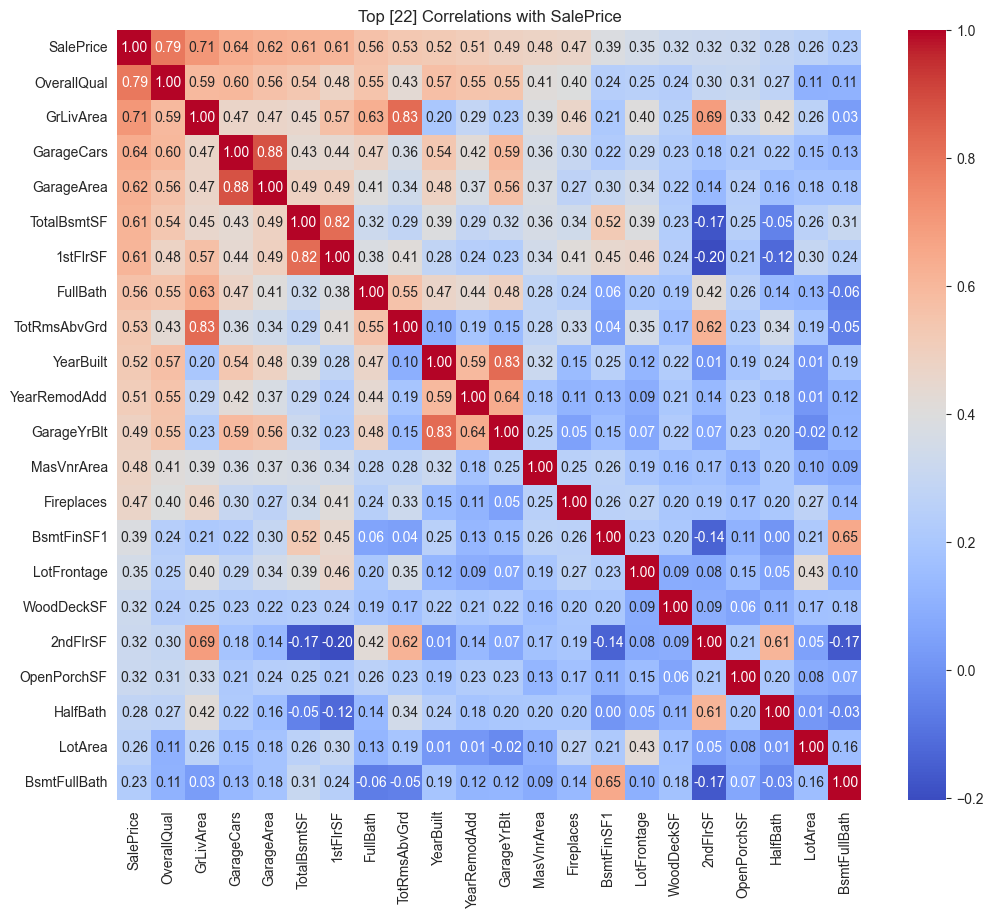

In [ ]:
correlations = df_train.select_dtypes(include=['int64', 'float64']).corr()['SalePrice']

num_correlations = 22

top_correlations = correlations.abs().nlargest(num_correlations).index

correlation_matrix = df_train[top_correlations].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Top [{num_correlations}] Correlations with SalePrice')
plt.show()

### Missing data analysis
2 continuous feature are missing data as well as 16 categorical features. The aim of this analysis is to identify if it is worth filling the gaps or if the feature should be dropped.

#### Continuous features
- `LotFrontage`, in housing, the frontage is an important part of the property that is defined by the distance of the house from the road. Hence, frontage gives an indication of how much more can be developed on the property, which can be seen has a benefit. This value can be influenced by zoning regulations and other factor. In this iteration, the median value of the group: `Neighborhood`, `LotConfig`, `MSZoning`, `MSSubClass` and `BldgType` to fill the gaps as these features seem impactful on the value.

- `GarageYrBlt`, represents the year the garage was built. Looking at the Garage properties from the empty houses, the `GarageArea` value is `0`. This is a strong indication the house has no Garage. Since it would be difficult to impute a value in this case, this feature will be used to extract two new features:
  - HasGarage, indicating whether or not the house has a garage
  - GarageBltAfter, indicating whether or not the garage was built after the house or if it was built at the same time.

In [ ]:
garage_feature_df = df_train[['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]
garage_feature_df

,GarageYrBlt,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,2003.0,Attchd,RFn,2,548,TA,TA
1,1976.0,Attchd,RFn,2,460,TA,TA
2,2001.0,Attchd,RFn,2,608,TA,TA
3,1998.0,Detchd,Unf,3,642,TA,TA
4,2000.0,Attchd,RFn,3,836,TA,TA
...,...,...,...,...,...,...,...
1455,1999.0,Attchd,RFn,2,460,TA,TA
1456,1978.0,Attchd,Unf,2,500,TA,TA
1457,1941.0,Attchd,RFn,1,252,TA,TA
1458,1950.0,Attchd,Unf,1,240,TA,TA


#### Categorical features
In the categorical features section, more feature are missing data. However, as studied previously, the Garage features missing are all an indication that there is no garage. As a result, we can start by imputing 'No Garage' where there are no values for the Garages features.

The `Alley` feature is missing 93% of the data, where the value is missing, the 'No Alley' value will be imputed.

The `MasVnrType` feature is missing around `60%` of values. Where missing, the value None will be imputed.

Some basement related features are missing data, we will look at `TotalBsmtSF` to understand if the house has a basement. After analysis it looks like `TotalBsmtSF` is 0 for these. As a result, we can conclude the house has no basement and assign the value `No basement`

Electrical - Has only a single instance with a missing value. We will look at the instance to understand if the value can be imputed. We're filling the mode for now as there is a single instance but in the future, we can also look at year built / neighborhood etc... to help getting closer to similar houses.

FireplaceQu - Empty values are probably due to the fact the house does not have a fireplace. We will be able to impute this from the Fireplaces feature

PoolQC - Is missing 99.5% of data. This is expected since Pools are a rare feature in a house. Looking at the Pool area feature we will impute the values accordingly

Fence - No Fence will be imputed when empty

MiscFeature - The value None will be imputed when there is no values

In [ ]:
cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df_train[df_train[cols].isna().all(axis=1)][cols + ['TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0
39,NaN,NaN,NaN,NaN,NaN,0
90,NaN,NaN,NaN,NaN,NaN,0
102,NaN,NaN,NaN,NaN,NaN,0
156,NaN,NaN,NaN,NaN,NaN,0
182,NaN,NaN,NaN,NaN,NaN,0
259,NaN,NaN,NaN,NaN,NaN,0
342,NaN,NaN,NaN,NaN,NaN,0
362,NaN,NaN,NaN,NaN,NaN,0
371,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
df_train[~df_train['Electrical'].notna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


## Data Preparation
### Feature Engineering
#### Custom Imputations

In [ ]:
# TODO Consider using custom transformation from sklearn library to simplify this process
# TODO CHECK FOR DUPLICATES IN DATA JUST IN CASE
# Continuous features
def create_garage_features(df):
  df_copy = df.copy()
  df_copy['HasGarage'] = df_copy['GarageArea'].apply(lambda x: 'N' if x == 0 else 'Y')
  df_copy['GarageBltAfter'] = df_copy.apply(lambda x: 'Y' if x['GarageYrBlt'] > x['YearBuilt'] else 'N', axis=1)
  return df_copy

def fill_LotFrontage(df):
  df_copy = df.copy()
  df_copy['LotFrontage'] = df_copy['LotFrontage'].fillna(df_copy.groupby(['Neighborhood', 'LotConfig', 'MSZoning', 'BldgType'])['LotFrontage'].transform('median'))
  # After imputations there was 80 values still left with nothing, also 1 column was removed from the groupping, we should investigate what to do, but for now assigning median
  df_copy['LotFrontage'] = df_copy['LotFrontage'].fillna(df_copy['LotFrontage'].median())
  return df_copy

# Categorical features
def impute_garage_feature(df):
  df_copy = df.copy()
  df_copy['GarageType'] = df_copy['GarageType'].fillna('No Garage')
  df_copy['GarageFinish'] = df_copy['GarageFinish'].fillna('No Garage')
  df_copy['GarageQual'] = df_copy['GarageQual'].fillna('No Garage')
  df_copy['GarageCond'] = df_copy['GarageCond'].fillna('No Garage')
  return df_copy

def impute_alley(df):
  df_copy = df.copy()
  df_copy['Alley'] = df_copy['Alley'].fillna('No Alley')
  return df_copy

def impute_masvnrtype(df):
  df_copy = df.copy()
  df_copy['MasVnrType'] = df_copy['MasVnrType'].fillna('None')
  # TODO MasVnrArea had 8 empty values, so far setting to 0 as it could mean 'None' but this needs to be verified
  df_copy['MasVnrArea'] = df_copy['MasVnrArea'].fillna(0)
  return df_copy

def impute_basement(df):
  df_copy = df.copy()
  df_copy['BsmtQual'] = df_copy['BsmtQual'].fillna('No Basement')
  df_copy['BsmtCond'] = df_copy['BsmtCond'].fillna('No Basement')
  df_copy['BsmtExposure'] = df_copy['BsmtExposure'].fillna('No Basement')
  df_copy['BsmtFinType1'] = df_copy['BsmtFinType1'].fillna('No Basement')
  df_copy['BsmtFinType2'] = df_copy['BsmtFinType2'].fillna('No Basement')
  return df_copy

def impute_fence(df):
  df_copy = df.copy()
  df_copy['Fence'] = df_copy['Fence'].fillna('No Fence')
  return df_copy

def impute_fireplaceq(df):
  df_copy = df.copy()
  df_copy['FireplaceQu'] = df_copy['FireplaceQu'].fillna('No Fireplace')
  return df_copy

def impute_poolqc(df):
  df_copy = df.copy()
  df_copy['PoolQC'] = df_copy['PoolQC'].fillna('No Pool')
  return df_copy

def impute_miscfeature(df):
  df_copy = df.copy()
  df_copy['MiscFeature'] = df_copy['MiscFeature'].fillna('None')
  return df_copy

def impute_electrical(df):
  df_copy = df.copy()
  df_copy['Electrical'] = df_copy['Electrical'].fillna(df_copy['Electrical'].mode()[0])
  return df_copy

def drop_columns(df):
  df_copy = df.copy()
  df_copy = df_copy.drop(columns=['Id', 'GarageYrBlt'])
  return df_copy

def apply_all(df):
  return drop_columns(create_garage_features(fill_LotFrontage(impute_garage_feature(impute_alley(impute_masvnrtype(impute_basement(impute_fence(impute_fireplaceq(impute_poolqc(impute_miscfeature(impute_electrical(df))))))))))))

def transform_and_extract_target(df, target_feature):
  df_copy = df.copy()
  target = df_copy.pop(target_feature)
  df_copy = apply_all(df_copy)
  return df_copy, target

X, y = transform_and_extract_target(df_train, 'SalePrice')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Transformations
##### Standard Scaler

In [ ]:
standard_scaler = StandardScaler()

##### OneHotEncoder

In [ ]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

#### Preprocessor

In [ ]:
continous_features_selector = make_column_selector(dtype_include=['int64', 'float64'])
categorical_features_selector = make_column_selector(dtype_include=['object'])

continuous_transformer = make_pipeline(SimpleImputer(strategy='mean'), standard_scaler)
categorical_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), ohe)

preprocessor = make_column_transformer(
     (continuous_transformer, continous_features_selector),
     (categorical_transformer, categorical_features_selector)
)

### Neural Network Data Preparation

In [ ]:
nn_preprocessor = clone(preprocessor)

X_train_processed = nn_preprocessor.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float64)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).view(-1, 1)

X_test_processed = nn_preprocessor.transform(X_test)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64).view(-1, 1)

## Model Implementation
### Stacked Model
#### Random Forest

In [ ]:
# Using log of difference like in the competition
def get_score(actual, pred):
    return np.sqrt(np.mean((np.log(actual) - np.log(pred))**2))

custom_scorer = make_scorer(get_score, greater_is_better=False)

# Unfortunately GridSearchCV was taking too long to complete, so parameters were chosen manually
random_forest_grid = {
    'randomforestregressor__n_estimators': [300, 500, 600],
    'randomforestregressor__max_depth': [2, 4],
    'randomforestregressor__min_samples_split': [2, 4],
    'randomforestregressor__max_features': [ 0.3, 0.4, 0.5]
}

search_random_forest = make_pipeline(preprocessor,
                                     TargetEncoder(random_state=42, smooth=10),
                                     RandomForestRegressor(random_state=42,
                                                           n_jobs=-1,
                                                           n_estimators=500,
                                                           max_depth=3,
                                                           min_samples_split=3,
                                                           max_features=0.4))

In [ ]:
# search_random_forest.fit(X_train, y_train)
# search_random_forest.best_estimator_

#### GradientBoosting

In [ ]:
# Unfortunately GridSearchCV was taking too long to complete, so parameters were chosen manually
gradient_boosting_grid = {
    'gradientboostingregressor__n_estimators': [300, 500, 600],
    'gradientboostingregressor__max_depth': [2, 4],
    'gradientboostingregressor__min_samples_split': [2, 4],
    'gradientboostingregressor__max_features': [0.3, 0.4, 0.5]
}

gradient_boosting = make_pipeline(preprocessor,
                                  TargetEncoder(random_state=42, smooth=10),
                                  GradientBoostingRegressor(random_state=42,
                                                            n_estimators=500,
                                                            max_depth=3,
                                                            min_samples_split=3,
                                                            max_features=0.4))

In [ ]:
# gradient_boosting.fit(X_train, y_train)
# gradient_boosting.best_estimator_

#### RidgeRegression

In [ ]:
ridge_regression_grid = {
    'ridge__alpha': [0.01, 0.1, 1],
    'ridge__max_iter': [1000, 2000, 3000]
}

ridge = GridSearchCV(make_pipeline(preprocessor,
                      TargetEncoder(random_state=42, smooth=10),
                      Ridge(random_state=42)),
                     ridge_regression_grid, cv=5, scoring=custom_scorer, n_jobs=-1)

In [ ]:
ridge.fit(X_train, y_train)
ridge.best_estimator_

#### Final Model

In [ ]:
stacked_model = StackingRegressor(
    estimators=[
        ('random_forest', search_random_forest),
        ('gradient_boosting', gradient_boosting),
        ('ridge', ridge.best_estimator_)
    ],
    final_estimator=LinearRegression(),
    n_jobs=-1
)

stacked_model.fit(X_train, y_train)

### Neural Network
What type of NN are we building ? ANN - There is no dependence between features, they are all quite independent. So we can use ANN for simplicity.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using [{device}] device")

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)

Using [cpu] device


In [ ]:
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
model = model.type(torch.float64)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

epochs = 5000
for epoch in range(epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/5000], Loss: 2299574467.3266
Epoch [200/5000], Loss: 1258896936.4376
Epoch [300/5000], Loss: 1117598213.5210
Epoch [400/5000], Loss: 967876134.5323
Epoch [500/5000], Loss: 927231169.8316
Epoch [600/5000], Loss: 824336109.5578
Epoch [700/5000], Loss: 728802385.3246
Epoch [800/5000], Loss: 768098809.1283
Epoch [900/5000], Loss: 717693249.8732
Epoch [1000/5000], Loss: 718963120.3665
Epoch [1100/5000], Loss: 676905511.7688
Epoch [1200/5000], Loss: 662886950.5287
Epoch [1300/5000], Loss: 708140006.0230
Epoch [1400/5000], Loss: 620118669.1513
Epoch [1500/5000], Loss: 658845815.0409
Epoch [1600/5000], Loss: 656614762.1686
Epoch [1700/5000], Loss: 639645185.1752
Epoch [1800/5000], Loss: 593212678.3013
Epoch [1900/5000], Loss: 604482531.4481
Epoch [2000/5000], Loss: 599803528.8313
Epoch [2100/5000], Loss: 599683553.1654
Epoch [2200/5000], Loss: 535164170.4597
Epoch [2300/5000], Loss: 607273986.4544
Epoch [2400/5000], Loss: 559430060.7463
Epoch [2500/5000], Loss: 533636564.4368
Epoch 

## Model Evaluation
### Stacked Model evaluation

In [ ]:
root_mean_squared_error(stacked_model.predict(X_test), y_test)

32341.985689068624

### Neural Network evaluation

In [ ]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_test_tensor)
    val_loss = criterion(val_outputs, y_test_tensor)
    print(f'Validation Loss: {val_loss.item():.4f}')
    rmse = torch.sqrt(val_loss)
    print(f'Validation RMSE: {rmse.item():.4f}')


Validation Loss: 805410528.4279
Validation RMSE: 28379.7556


The Neural Network appears to achieve better results than the Stacked model. First, its training time was 1m28s compared to 55mn for the Stacked model. But also, the Neural Network's validation RMSE is `28379.7556` compared to `32341.9857`. Since RMSE punishes bigger mistakes more than smaller ones an assumption could be that the Neural Network does smaller mistakes than the Stacked model when predicting the values. The results should be confirmed at submission which will help understanding if any model was overfitting or not for example.

## Model Submissions
### Neural Network Submission

In [ ]:
df_test_nn = df_test.copy()
id_nn = df_test_nn['Id']

df_test_nn = apply_all(df_test_nn)

X_competition_tensor = torch.tensor(nn_preprocessor.transform(df_test_nn), dtype=torch.float64)

model.eval()
with torch.no_grad():
    predictions_tensor = model(X_competition_tensor)
    predictions = predictions_tensor.numpy().flatten()

pd.DataFrame({'Id': id_nn, 'SalePrice': predictions}).to_csv('nn_submission.csv', index=False)

### Stacked Model Submission

In [ ]:
df_test_stacked = df_test.copy()
id_col = df_test_stacked['Id']

df_test_stacked = apply_all(df_test_stacked)

stack_pred = stacked_model.predict(df_test_stacked)
pd.DataFrame({'Id': id_col, 'SalePrice': stack_pred}).to_csv('stacked_submission.csv', index=False)

The submission confirms the results achieved previously as the Neural Network achieved a better score than the Stacked model.

## Discussion

This experiment compared the use of Stacked models against Neural Network and explored if any of these methods was more efficient than the other. The results demonstrated that while the Stacked model performed quite well in terms of achieved score compared to the Neural Network, it ended up achieving less, while taking significant training time to complete. The experiment started by exploring the data from the selected dataset coming from the House Prices Advanced Regression Technique Kaggle competition in order to understand its nature. Once completed, the data analysis highlighted different missing values in the data which were filled using careful investigation to ensure the best representation while conserving as much data as possible for training. The moddels where then built, with the first being a Stacked model using a combination of the most advanced Machine Learning models known (RandomForest and GradientBoosting), the second being a simple Artifical Neural Network using three hidden layers with RELU as activation function, dropout set to 0.3 to prevent overfitting and a last linear output layer for the final prediction. The models were then evaluated based on RMSE and compared. Finally, both models were used to make predictions on the test data which was then submitted to the competition as a final layer of validation for the results.

The experiment also highlights that while Neural Network are known to be more complex in terms of implementation than regular Machine Learning models, this turned out not to be so true in the present case. Especially, since the Stacked model required investigating and tuning several different Machine Learning models while the Neural Network relied on normal concepts such as dropout, activation functions and hidden layers to perform the prediction task.

While this achieves a first iteration of the experiment, a lot more can be achieved in the future. First, the feature engineering part should be further investigated as it has been seen that a lot of features have high correlation coefficient between each others. This would help building features the model can interpret, while reducing the dimensionality naturally. Dimensionality reduction techniques using PCA should also be investigated as they could help reducting the Stacked model's training time, reducing the gap with the Neural Network in this area.

Another area of improvement relates on the interpretability and explainability of both models. As of now, it is difficult to understand what characteristics are impactful in both model's decision making and identifying these would be beneficial to drive better feature engineering iterations. The use of `SHAP` could be investigated to fill this gap. In addition, some relevant plots highlighting the distribution difference between the predictions of the NN and the Stacked model could be displayed to understand the main differences on how each model does its predictions.

The feature engineering was made based on the training set but not the testing. As a result, SimpleImputer was used to cover some cases where the training data was not missing anything, but testing was. This is a conscious decision based on the fact test.csv should completely be unseen before doing it. Hence, we must be able to cover for cases where we did not plan data would be missing.

A noteworthy mention should be made about how the data was initially explored. The consideration that was made was that, in a real-life scenario, only the data contained in `train.csv` would have been available. Therefore, while `test.csv` was also available for analysis, it was not accounted for during this phase. This has caused that it was discovered some features were missing values in the `test.csv` file but not in `train.csv` file. Hence, `SimpleImputer` was used to fill the gaps using `mean` for continous values and `mode` for categorical features since it would not have been possible to know that in advance.

Finally, the Neural Network Should be trained with a different loss function that is the same as the Stacked model, using the RMSE of the log from the difference between the predicted value and the actual value. This, to understand if the model can achieve better performance by adjusting the loss function to the one that is used to evaluate the models in the competition.